In [90]:
import os
import warnings
from collections import Counter
from datetime import datetime
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from deep_translator import GoogleTranslator
from fastai.callback.progress import CSVLogger
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.learner import DataLoaders
from fastai.metrics import RocAuc
from fastai.optimizer import OptimWrapper
from fastai.vision.all import Learner
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel

In [91]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [92]:
import pickle
SIM_THRESHOLD = 0.80
# 5/0
data_translated = {}
with open('data_translated.pkl', 'rb') as f:
    data_translated = pickle.load(f)

In [93]:
original_eng = pd.read_csv('public_data/train/track_a/eng.csv')
original_eng['comment'] = 'original_eng'

In [94]:
df_translated = pd.concat([original_eng] + list(data_translated.values()), ignore_index=True)
df_translated.to_csv('df_translated.csv', index=False)
display(df_translated.head())

,id,text,Anger,Fear,Joy,Sadness,Surprise,comment
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0,original_eng
1,eng_train_track_a_00002,"Well she's not gon na last the whole song like that, so since I'm behind her and the audience can't see below my torso pretty much, I use my hand to push down on the lid and support her weight.",0,0,1,0,0,original_eng
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to move next to me and start clinging to my arms.,0,0,0,0,0,original_eng
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1,original_eng
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0,original_eng


In [95]:
# df_translated = pd.read_csv('df_translated_cleaned.csv')

In [96]:
# df_translated = df_translated[df_translated['comment'].isin(('backtranslate_de', 'original_eng'))].copy()

In [97]:
MAX_LEN = original_eng.text.str.len().max()
# MAX_LEN = df_translated.text.str.len().max()

In [98]:
df_translated = df_translated.dropna(subset=['comment'])

In [99]:
# Dataset definition
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

class CorrelationAwareLoss(nn.Module):
    def __init__(self, pos_weight, correlation_matrix, base_loss=nn.BCEWithLogitsLoss):
        """
        Args:
            pos_weight (torch.Tensor): Weights for positive samples of each class.
            correlation_matrix (torch.Tensor): Correlation matrix of labels.
            base_loss (nn.Module): Base loss function (default: BCEWithLogitsLoss).
        """
        super(CorrelationAwareLoss, self).__init__()
        self.pos_weight = pos_weight
        self.correlation_matrix = correlation_matrix
        self.base_loss = base_loss(pos_weight=self.pos_weight)

    def forward(self, logits, labels):
        # Compute the weighted BCEWithLogitsLoss
        weighted_loss = self.base_loss(logits, labels)

        # Compute pairwise correlation adjustment
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        batch_size = preds.size(0)

        # Penalize based on how predictions align with label correlation
        correlation_loss = torch.sum(
            (preds.unsqueeze(2) - preds.unsqueeze(1)) * self.correlation_matrix.unsqueeze(0)
        ) / batch_size

        # Combine the base loss and correlation loss
        return weighted_loss + 0.1 * correlation_loss

In [100]:
DEBUG = None

In [101]:

class RobertaMultiLabel(torch.nn.Module):
    def __init__(self, num_labels):
        super(RobertaMultiLabel, self).__init__()
        self.bert = RobertaModel.from_pretrained("FacebookAI/roberta-base", num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, x):
        global DEBUG
        input_ids, attention_mask = x
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        DEBUG = outputs

        pooled_output = self.dropout(outputs.last_hidden_state[:, 0])
        return self.fc(pooled_output)
    

In [102]:
# drop nas from the dataset where the text is missing
df_translated = df_translated.dropna(subset=['text'])
# df_translated = df_translated[df_translated['comment'] != 'backtranslate_de']

In [103]:
# train_data, valid_data = train_test_split(df_translated, test_size=0.25, random_state=42)
train_data, valid_data = train_test_split(original_eng, test_size=0.25, random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [104]:
labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [105]:
train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

# Define model and training components
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda")
print(f"Using device: {device}")
model = RobertaMultiLabel(len(labels)).to(device)


# Compute pos_weight for BCEWithLogitsLoss 
values = train_data[labels].values.tolist()
labels_tensor = torch.tensor(values, dtype=torch.float)
num_positives = labels_tensor.sum(dim=0)
num_negatives = labels_tensor.shape[0] - num_positives
pos_weight = num_negatives / num_positives
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

# Define the loss function
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# loss_func = CorrelationAwareLoss(pos_weight=class_weights, correlation_matrix=correlation_matrix)
# loss_func = nn.BCEWithLogitsLoss()


Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2950103/2857014135.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)


In [106]:
# Add timestamp to the directory name
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
name = "roberta"
output_path = Path(f'model_{name}_{timestamp}')
output_path.mkdir(exist_ok=True, parents=True)

# FastAI DataLoaders
dls = DataLoaders(train_loader, valid_loader, device=device)

# Define Learner
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[RocAuc()],
    path=output_path
)

# Callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_valid'),
    EarlyStoppingCallback(monitor='valid_loss', patience=9),
    CSVLogger()
]

In [107]:
learn.fit_one_cycle(n_epoch=5, reset_opt=True, lr_max=1e-4, wd=1e-2, cbs=cbs)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.867538,0.790802,0.811798,00:13
1,0.728845,0.657875,0.815406,00:13
2,0.576188,0.667373,0.826820,00:13
3,0.358431,0.714386,0.831559,00:13
4,0.228364,0.727233,0.833976,00:13


Better model found at epoch 0 with valid_loss value: 0.7908023595809937.
Better model found at epoch 1 with valid_loss value: 0.6578747034072876.


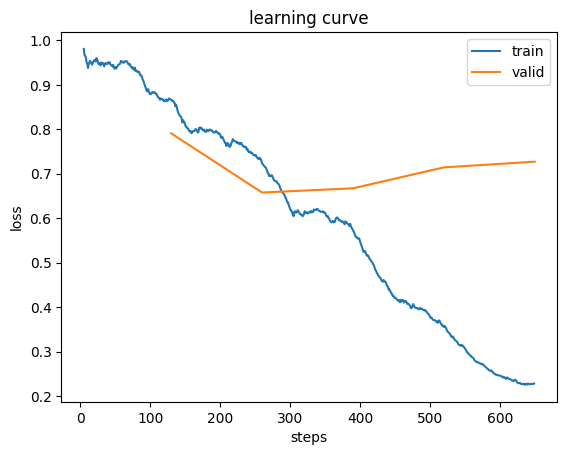

In [108]:
learn.recorder.plot_loss()
plt.show()

In [109]:
# save learn model in pth format
learn.save(f'model_last')


Path('model_roberta_2025-02-04_15-57-10/models/model_last.pth')

In [110]:
# def predict_and_save_with_texts(learner, texts, output_csv):
#     if learner.dls.valid is None:
#         raise ValueError("The Learner does not have a validation DataLoader.")
    
#     preds, targs = learner.get_preds(dl=learner.dls.valid)

#     preds_binary = (preds > 0).int()

#     results_df = pd.DataFrame({
#         "Text": texts,
#         "True Labels": [list(map(int, x)) for x in targs],
#         "Predicted Labels": [list(map(int, x)) for x in preds_binary]
#     })

#     results_df.to_csv(output_csv, index=False)
#     print(f"Predictions saved to {output_csv}")


# results_path = Path(f"results_{name}_{timestamp}")
# results_path.mkdir(exist_ok=True, parents=True)
# output_csv = f"{results_path}/validation_predictions.csv"

# # Load best model
# best_model_path = output_path / 'models' / 'best_valid.pth'
# #learn.load(best_model_path.stem)

# # Get validation texts and make predictions
# validation_texts = valid_data["text"].tolist()
# predict_and_save_with_texts(learn, validation_texts, output_csv=output_csv)


In [111]:

dev_df = pd.read_csv('public_data_test/track_a/dev/eng.csv')
# dev_df = valid_data
dev_df.head()


,id,text,anger,fear,joy,sadness,surprise
0,eng_dev_track_a_00001,Older sister (23 at the time) is a Scumbag Stacy.,1,0,0,0,0
1,eng_dev_track_a_00002,"And I laughed like this: garhahagar, because my mouth was full of cotton and shit to bite down on and sharp objects and drills.",0,1,0,0,0
2,eng_dev_track_a_00003,It overflowed and brown shitty diarrhea water came flooding under the stall wall into my wife's stall.,1,1,0,1,1
3,eng_dev_track_a_00004,Its very dark and foggy.,0,1,0,0,0
4,eng_dev_track_a_00005,"Then she tried to, like, have sex with/strangle everyone.",1,1,0,0,1


In [112]:
# Function to preprocess and predict
def predict_classes(learner, texts, tokenizer, max_len=128):
    predictions = []

    learner.model.eval()
    with torch.no_grad():
        for text in texts:
            # Tokenize and prepare input
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            # Make predictions
            logits = learner.model((input_ids, attention_mask))
            probs = torch.sigmoid(logits)  # Multi-label classification
            predicted_labels = (probs > 0.5).int().tolist()[0]  # Binary predictions
            # predicted_labels = (logits > 0).int().tolist()[0]  # Binary predictions

            predictions.append(predicted_labels)
    return predictions


# Load best model
best_model_path = output_path / 'models' / 'best_valid.pth'
learn.load(best_model_path.stem)


# Apply the model to the dataset
# drop dev_df with missing text
dev_df = dev_df.dropna(subset=['text'])
texts = dev_df["text"].tolist()  # Handle missing texts
predictions = predict_classes(learn, texts, tokenizer)

# Add predictions to the DataFrame
emotion_labels = ["pred_anger", "pred_fear", "pred_joy", "pred_sadness", "pred_surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
dev_df[emotion_labels] = prediction_df.values

# Save the true and predicted labels as string lists
# dev_df["True Labels"] = dev_df[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values.tolist()
dev_df["True Labels"] = dev_df[["anger", "fear", "joy", "sadness", "surprise"]].values.tolist()

dev_df["Predicted Labels"] = dev_df[emotion_labels].values.tolist()

# Convert lists to strings
dev_df["True Labels"] = dev_df["True Labels"].apply(lambda x: str(x))
dev_df["Predicted Labels"] = dev_df["Predicted Labels"].apply(lambda x: str(x))

# Save the updated DataFrame to a new file
results_path = Path(f"results_{name}_{timestamp}")
results_path.mkdir(exist_ok=True, parents=True)
output_csv = f"{results_path}/dev_predictions.csv"

dev_df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")

/mnt/bulk-sirius/anton/coding/SemEval/.venv/lib/python3.12/site-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Predictions saved to results_roberta_2025-02-04_15-57-10/dev_predictions.csv
